In [1]:
#import xarray as xr

import numpy as np
import pandas as pd
# from pathlib import Path

# import os, sys
# import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')
from scipy import signal
# from scipy import stats
# from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

# Tidally filter and then 40 day boxcar filter the jersey point, franks tract, and holland cut data

<AxesSubplot:xlabel='datetime'>

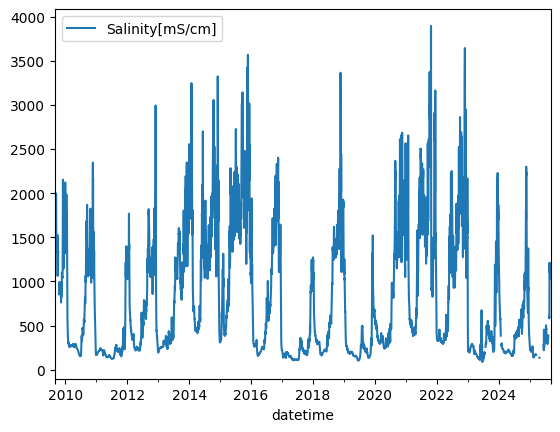

In [5]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
dtformat = '%Y-%m-%dT%H:%M:%S'
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk.drop(columns=['user_flag']))

jp_filt.plot()

In [6]:
jp_filt

,Salinity[mS/cm]
datetime,
2009-08-29 15:15:00,NaN
2009-08-29 15:30:00,NaN
2009-08-29 15:45:00,NaN
2009-08-29 16:00:00,NaN
2009-08-29 16:15:00,NaN
...,...
2025-09-07 22:00:00,NaN
2025-09-07 22:15:00,NaN
2025-09-07 22:30:00,NaN


<AxesSubplot:xlabel='datetime'>

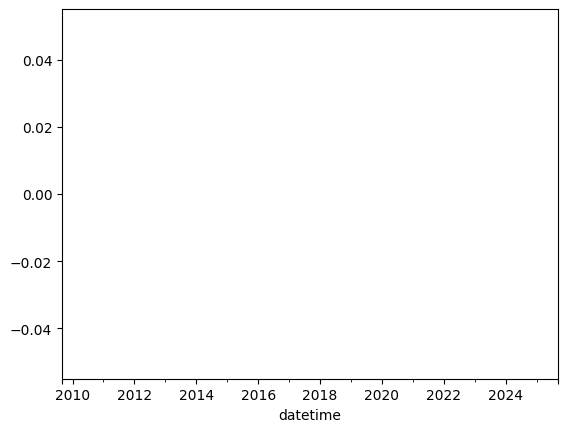

In [9]:
#try a boxcar to compare with the elliptical filter
#30 minute sampling frequency to Hertz
ptide=15 #data collection period in minutes

M_40d=int((60*24*40)/ptide) #size of the window in samples
box_40d = np.ones(M_40d)/M_40d

#to implement the box car, convolve with the window, then trim the errorneous values as the beginnibg and end when using this 'same' method
Njp=len(jp_filt["Salinity[mS/cm]"])
Nfrk=len(frk_filt["Salinity[mS/cm]"])
Nhol2=len(hol2_dms_filt["Salinity[mS/cm]"])

jp_bc = jp_filt["Salinity[mS/cm]"].sub(signal.convolve(jp_filt["Salinity[mS/cm]"],box_40d,mode='same'))
# ptreyes.subtide.sub(signal.convolve(ptreyes.subtide,box_18d,mode='same'))
# #ptreyes['box_40d_filt'] =  ptreyes.subtide-signal.convolve(ptreyes.subtide,box_40d_sig)
# ptreyes['box_40d_filt'] =  ptreyes.subtide-signal.convolve(ptreyes.subtide,box_40d,mode='same')
# ptreyes['box_100d_filt'] = ptreyes.subtide-signal.convolve(ptreyes.subtide,box_100d,mode='same')
# ptreyes['box_190d_filt'] = ptreyes.subtide-signal.convolve(ptreyes.subtide,box_190d,mode='same')


# monterey['box_18d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_18d,mode='same')
# monterey['box_40d_filt'] =  monterey.subtide-signal.convolve(monterey.subtide,box_40d,mode='same')
# monterey['box_100d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_100d,mode='same')
# monterey['box_190d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_190d,mode='same')

#throw out the first and last M entries due to width of box car
jp_bc[0:M_40d] = np.nan
jp_bc[Njp-M_40d:] = np.nan

jp_bc.plot()
# ptreyes['box_18d_filt'][0:M_18d] = np.nan
# ptreyes['box_18d_filt'][Npr-M_18d:] = np.nan
# ptreyes['box_40d_filt'][0:M_40d] = np.nan
# ptreyes['box_40d_filt'][Npr-M_40d:] = np.nan
# ptreyes['box_100d_filt'][0:M_100d] = np.nan
# ptreyes['box_100d_filt'][Npr-M_100d:] = np.nan
# ptreyes['box_190d_filt'][0:M_190d] = np.nan
# ptreyes['box_190d_filt'][Npr-M_190d:] = np.nan

# monterey['box_18d_filt'][0:M_18d] = np.nan
# monterey['box_18d_filt'][Nmb-M_18d:] = np.nan
# monterey['box_40d_filt'][0:M_40d] = np.nan
# monterey['box_40d_filt'][Nmb-M_40d:] = np.nan
# monterey['box_100d_filt'][0:M_100d] = np.nan
# monterey['box_100d_filt'][Nmb-M_100d:] = np.nan
# monterey['box_190d_filt'][0:M_190d] = np.nan
# monterey['box_190d_filt'][Nmb-M_190d:] = np.nan


In [10]:
 M_40d

3840

<AxesSubplot:xlabel='datetime'>

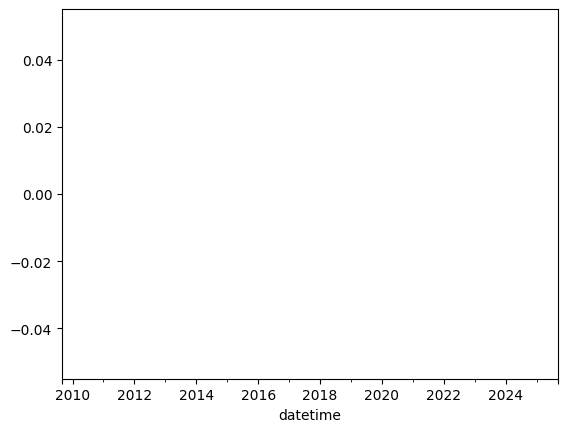

In [11]:
test = jp_filt["Salinity[mS/cm]"].sub(signal.convolve(jp_filt["Salinity[mS/cm]"],box_40d,mode='same'))
test.plot()

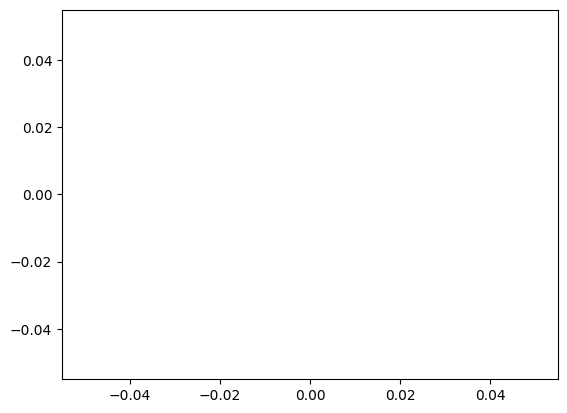

In [13]:
plt.plot(signal.convolve(jp_filt["Salinity[mS/cm]"],box_40d,mode='same'))